In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.rcParams['figure.figsize'] = (16, 12)

from wordcloud import WordCloud
import os
import requests
from IPython.display import Image, display

In [4]:
CONFIG_PATTERN = 'http://api.themoviedb.org/3/configuration?api_key={key}'
IMG_PATTERN = 'http://api.themoviedb.org/3/movie/{imdbid}/images?api_key={key}' 
KEY = '<TMDB_API_KEY>'
            
config = requests.get(CONFIG_PATTERN.format(key=KEY)).json()
base_url = config['images']['base_url']

def show_poster(imdbid):

    imdbid = 'tt{}'.format(imdbid)
    posters = requests.get(IMG_PATTERN.format(key=KEY,imdbid=imdbid)).json()['posters']
    poster = posters[0]
    rel_path = poster['file_path']
    url = "{0}{1}{2}".format(base_url, 'w185', rel_path)
    
    im = Image(url)
    display(im)

In [5]:
def show_stats(data_name):
    
    print('Stats for {}'.format(data_name))
    
    df_movie = pd.read_csv(os.path.join(data_name, 'movies.csv'), index_col=0)
    df_rating = pd.read_csv(os.path.join(data_name, 'ratings.csv'))
    df_rating = df_rating.drop(columns='timestamp')
    
    nnz_count = df_rating.shape[0]
    print(f'Rating count: {nnz_count}')
    row_count = df_rating['userId'].nunique()
    print(f'User count: {row_count}')
    col_count = df_rating['movieId'].nunique()
    print(f'Movie count: {col_count}')
    density = nnz_count / (row_count * col_count)
    print(f'Density of the Matrix: {density:.5f}')
    
    user_group = df_rating.drop(columns='movieId').groupby('userId')
    user_rating_count = user_group.count()['rating']
    row_max = user_rating_count.max()
    row_min = user_rating_count.min()
    row_ave = user_rating_count.mean()

    print(f'Max # movies rated by a user: {row_max}')
    print(f'Min # movies rated by a user: {row_min}')
    print(f'Average # movies rated by a user: {row_ave:.2f}')

    movie_group = df_rating.drop(columns='userId').groupby('movieId')
    movie_rating_count = movie_group.count()['rating']
    col_max = movie_rating_count.max()
    col_min = movie_rating_count.min()
    col_ave = movie_rating_count.mean()

    print(f'Max # users rated a movie: {col_max}')
    print(f'Min # users rated a movie: {col_min}')
    print(f'Average # users rated a movie: {col_ave:.2f}')

In [6]:
show_stats('ml-20m')

Stats for ml-20m
Rating count: 20000263
User count: 138493
Movie count: 26744
Density of the Matrix: 0.00540
Max # movies rated by a user: 9254
Min # movies rated by a user: 20
Average # movies rated by a user: 144.41
Max # users rated a movie: 67310
Min # users rated a movie: 1
Average # users rated a movie: 747.84


In [7]:
show_stats('ml-25m')

Stats for ml-25m
Rating count: 25000095
User count: 162541
Movie count: 59047
Density of the Matrix: 0.00260
Max # movies rated by a user: 32202
Min # movies rated by a user: 20
Average # movies rated by a user: 153.81
Max # users rated a movie: 81491
Min # users rated a movie: 1
Average # users rated a movie: 423.39


In [8]:
df_movie = pd.read_csv('ml-25m/movies.csv', index_col=0)

In [9]:
df_movie.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [10]:
df_rating = pd.read_csv('ml-25m/ratings.csv')
df_rating = df_rating.drop(columns='timestamp')

In [11]:
df_rating.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


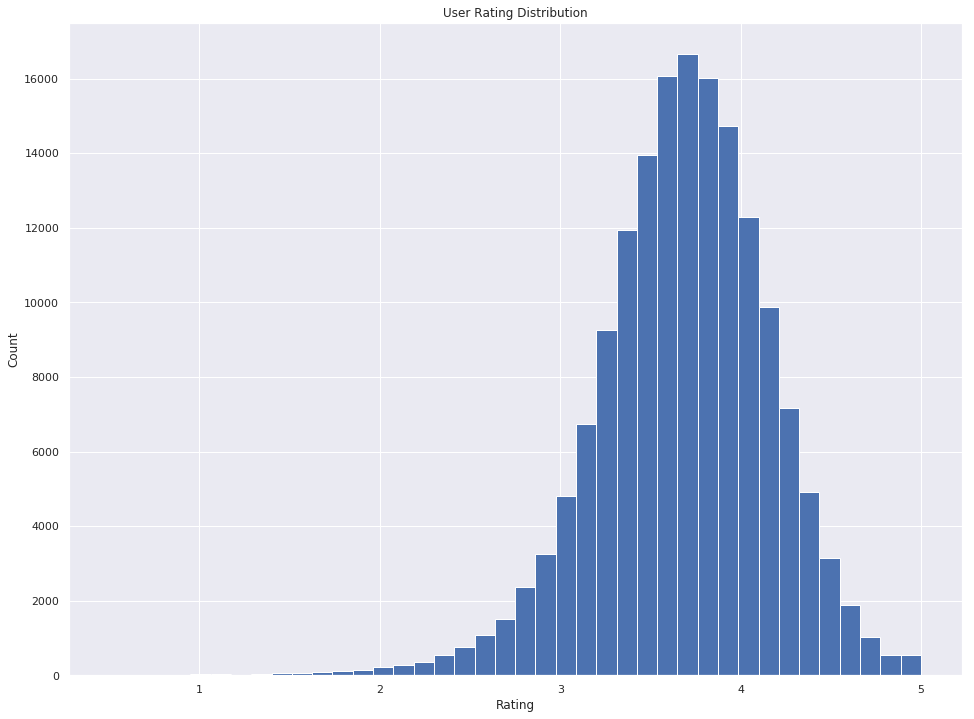

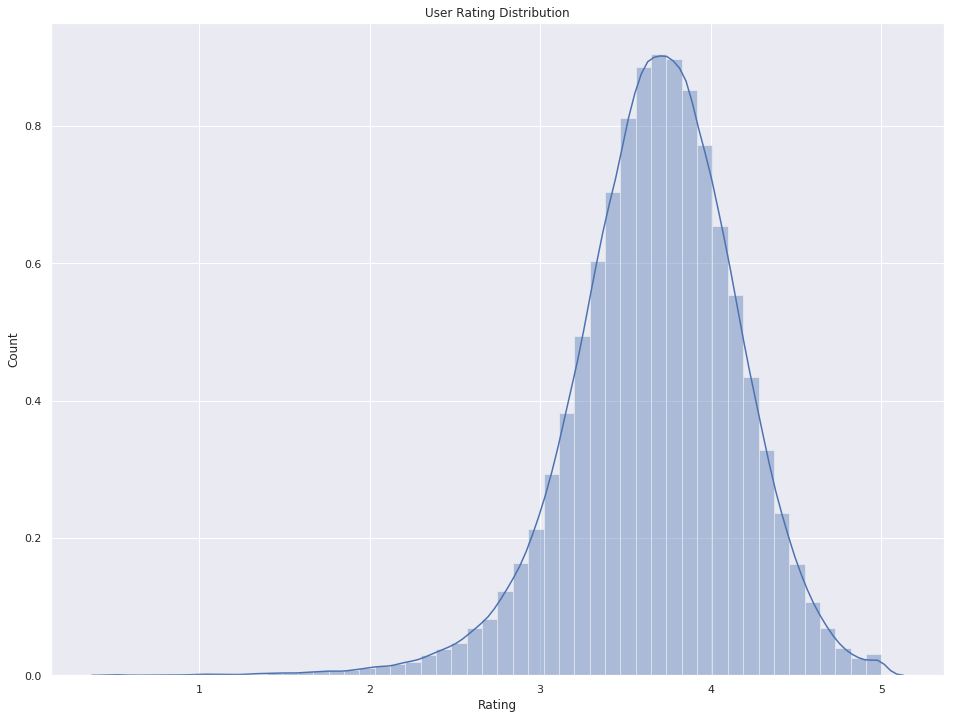

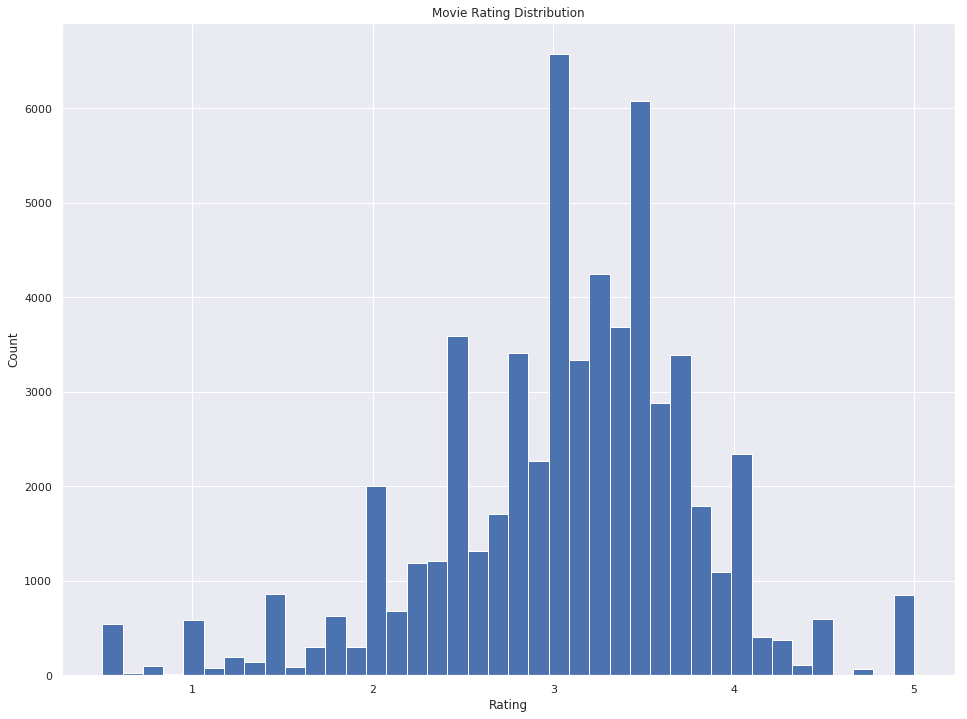

In [12]:
# Row Stats
user_group = df_rating.drop(columns='movieId').groupby('userId')
user_group['rating'].mean().hist(bins=40)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('User Rating Distribution')
plt.show()

sns.distplot(user_group['rating'].mean())
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('User Rating Distribution')
plt.show()

movie_group = df_rating.drop(columns='userId').groupby('movieId')
movie_group['rating'].mean().hist(bins=40)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Movie Rating Distribution')
plt.show()

In [13]:
movie_rating = movie_group.agg(['count', 'mean'])
movie_rating.columns = movie_rating.columns.get_level_values(1)
movie_rating.head()

,count,mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [14]:
most_popular_movie_id = movie_rating['count'].idxmax()
print(df_movie.loc[most_popular_movie_id]['title'])
print(movie_rating.loc[most_popular_movie_id])

Forrest Gump (1994)
count    81491.000000
mean         4.048011
Name: 356, dtype: float64


In [15]:
movie_rating.sort_values(by='mean', ascending=False).head()

,count,mean
movieId,,
136782,1,5.0
186119,1,5.0
137032,1,5.0
184643,1,5.0
137038,1,5.0


In [16]:
movie_rating_filtered = movie_rating[movie_rating['count'] > 2000]

In [17]:
df_link = pd.read_csv('ml-25m/links.csv', index_col=0, dtype={'imdbId': str})
df_link.head()

,imdbId,tmdbId
movieId,,
1,0114709,862.0
2,0113497,8844.0
3,0113228,15602.0
4,0114885,31357.0
5,0113041,11862.0


In [18]:
top_20 = movie_rating_filtered.sort_values(by='mean', ascending=False).head(n=20)
top_20['title'] = df_movie.loc[top_20.index.tolist()]['title']
top_20['imdbid'] = df_link.loc[top_20.index.tolist()]['imdbId']
top_20

,count,mean,title,imdbid
movieId,,,,
318,81482,4.413576,"Shawshank Redemption, The (1994)",0111161
858,52498,4.324336,"Godfather, The (1972)",0068646
50,55366,4.284353,"Usual Suspects, The (1995)",0114814
1221,34188,4.261759,"Godfather: Part II, The (1974)",0071562
2019,13367,4.254769,Seven Samurai (Shichinin no samurai) (1954),0047478
527,60411,4.247579,Schindler's List (1993),0108052
1203,16569,4.243014,12 Angry Men (1957),0050083
904,20162,4.237948,Rear Window (1954),0047396
2959,58773,4.228311,Fight Club (1999),0137523


Shawshank Redemption, The (1994)
4.414


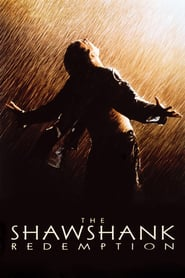

Godfather, The (1972)
4.324


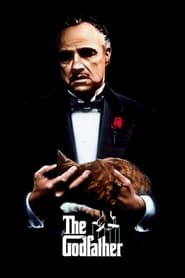

Usual Suspects, The (1995)
4.284


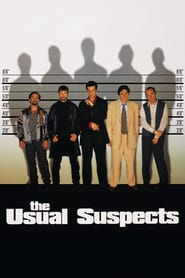

Godfather: Part II, The (1974)
4.262


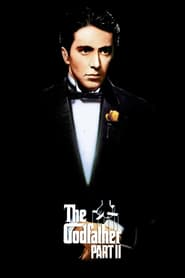

Seven Samurai (Shichinin no samurai) (1954)
4.255


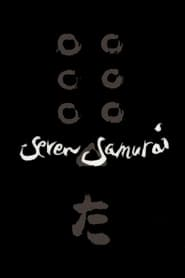

Schindler's List (1993)
4.248


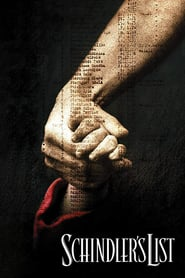

12 Angry Men (1957)
4.243


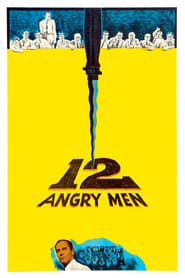

Rear Window (1954)
4.238


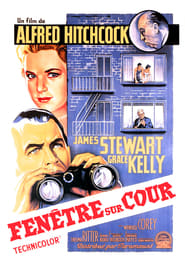

Fight Club (1999)
4.228


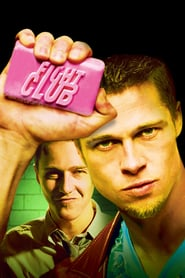

One Flew Over the Cuckoo's Nest (1975)
4.219


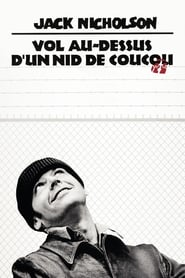

Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
4.216


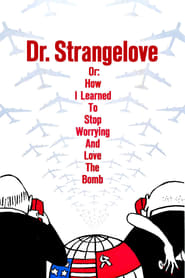

Spirited Away (Sen to Chihiro no kamikakushi) (2001)
4.212


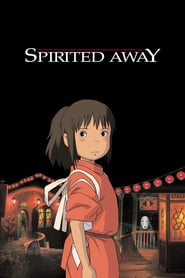

Casablanca (1942)
4.207


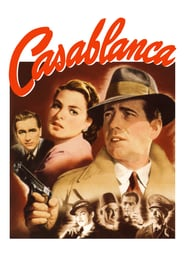

Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
4.207


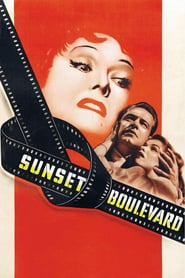

Third Man, The (1949)
4.201


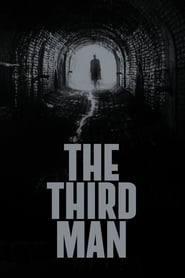

Lives of Others, The (Das leben der Anderen) (2006)
4.200


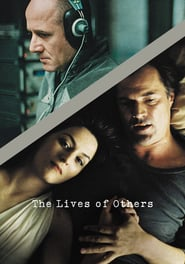

Paths of Glory (1957)
4.199


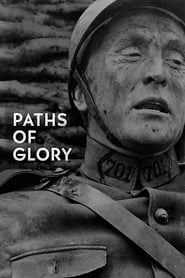

North by Northwest (1959)
4.197


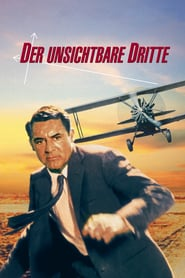

Double Indemnity (1944)
4.194


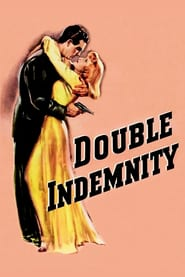

Pulp Fiction (1994)
4.189


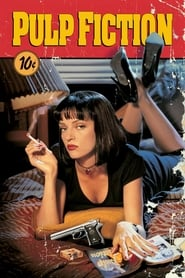

In [19]:
for movie in top_20.itertuples():
    print('======')
    print(movie.title)
    print(f'{movie.mean:.3f}')
    show_poster(movie.imdbid)

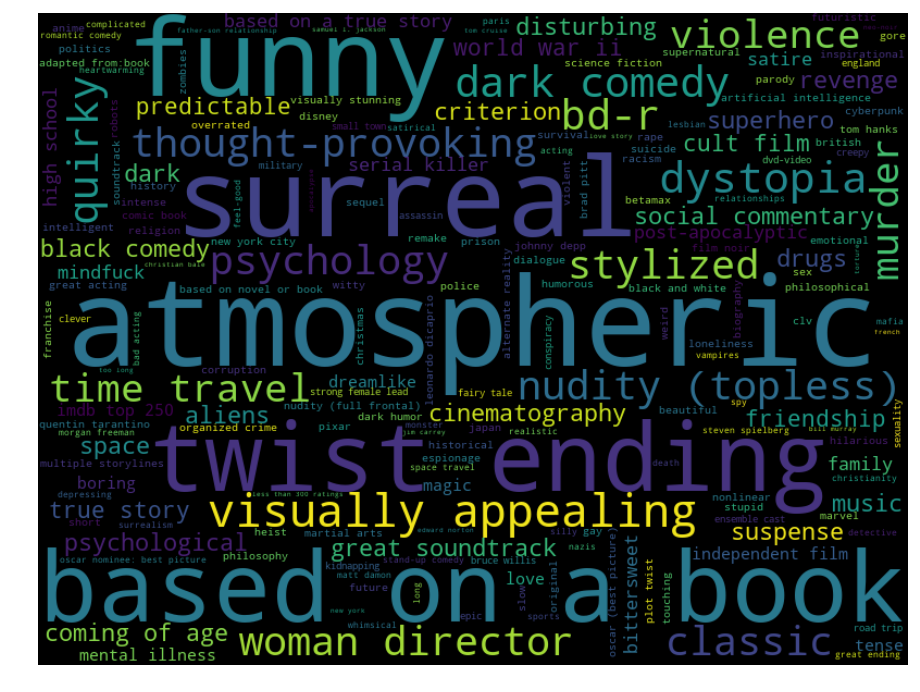

In [20]:
genres_unique = pd.DataFrame(df_movie['genres'].str.split('|').tolist()).stack().unique()

df_tag = pd.read_csv('ml-25m/tags.csv')

df_tag = df_tag[pd.notnull(df_tag['tag'])]

data = df_tag['tag'].apply(lambda x: x.lower())

tag2freq = data.groupby(data).count()

for genre in genres_unique:
    genre = genre.lower()
    if genre in tag2freq:
        tag2freq.pop(genre)

im = WordCloud(width=800, height=600).generate_from_frequencies(tag2freq)

plt.imshow(im, interpolation='bilinear')
plt.axis("off")
plt.show()